In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [ ]:
!pip install --upgrade diffusers transformers scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 99.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 89.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
from diffusers import StableDiffusionPipeline
from matplotlib import pyplot as plt
import os
import re
import numpy as np
from sklearn.model_selection import train_test_split
import shutil

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/Dataset/Data.csv")

In [ ]:
# dropping columns we don't need
df = df.drop(['Instructions', 'Ingredients', 'Unnamed: 0'], axis=1)
df.head()

,Title,Image_Name,Cleaned_Ingredients
0,Miso-Butter Roast Chicken With Acorn Squash Pa...,miso-butter-roast-chicken-acorn-squash-panzanella,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher..."
1,Crispy Salt and Pepper Potatoes,crispy-salt-and-pepper-potatoes-dan-kluger,"['2 large egg whites', '1 pound new potatoes (..."
2,Thanksgiving Mac and Cheese,thanksgiving-mac-and-cheese-erick-williams,"['1 cup evaporated milk', '1 cup whole milk', ..."
3,Italian Sausage and Bread Stuffing,italian-sausage-and-bread-stuffing-240559,"['1 (¾- to 1-pound) round Italian loaf, cut in..."
4,Newton's Law,newtons-law-apple-bourbon-cocktail,"['1 teaspoon dark brown sugar', '1 teaspoon ho..."


In [ ]:
# removing the numbers from the image name for convenience
df['Image_Name'] = df['Image_Name'].str.replace(r'\d+', ' ')
df['Image_Name'] = df['Image_Name'].str.replace(r'-\s', ' ')
df.head()

<ipython-input-6-ccb88b00c5b3>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Image_Name'] = df['Image_Name'].str.replace(r'\d+', ' ')
<ipython-input-6-ccb88b00c5b3>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Image_Name'] = df['Image_Name'].str.replace(r'-\s', ' ')


,Title,Image_Name,Cleaned_Ingredients
0,Miso-Butter Roast Chicken With Acorn Squash Pa...,miso-butter-roast-chicken-acorn-squash-panzanella,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher..."
1,Crispy Salt and Pepper Potatoes,crispy-salt-and-pepper-potatoes-dan-kluger,"['2 large egg whites', '1 pound new potatoes (..."
2,Thanksgiving Mac and Cheese,thanksgiving-mac-and-cheese-erick-williams,"['1 cup evaporated milk', '1 cup whole milk', ..."
3,Italian Sausage and Bread Stuffing,italian-sausage-and-bread-stuffing,"['1 (¾- to 1-pound) round Italian loaf, cut in..."
4,Newton's Law,newtons-law-apple-bourbon-cocktail,"['1 teaspoon dark brown sugar', '1 teaspoon ho..."


In [ ]:
df['Image_Name'] = df['Image_Name']+'.jpg'
df.head()

,Title,Image_Name,Cleaned_Ingredients
0,Miso-Butter Roast Chicken With Acorn Squash Pa...,miso-butter-roast-chicken-acorn-squash-panzane...,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher..."
1,Crispy Salt and Pepper Potatoes,crispy-salt-and-pepper-potatoes-dan-kluger.jpg,"['2 large egg whites', '1 pound new potatoes (..."
2,Thanksgiving Mac and Cheese,thanksgiving-mac-and-cheese-erick-williams.jpg,"['1 cup evaporated milk', '1 cup whole milk', ..."
3,Italian Sausage and Bread Stuffing,italian-sausage-and-bread-stuffing .jpg,"['1 (¾- to 1-pound) round Italian loaf, cut in..."
4,Newton's Law,newtons-law-apple-bourbon-cocktail.jpg,"['1 teaspoon dark brown sugar', '1 teaspoon ho..."


In [ ]:
# checking null values
df.isnull().sum()

Title                  5
Image_Name             0
Cleaned_Ingredients    0
dtype: int64

In [ ]:
# dropping the rows with null values
df.dropna(inplace=True)
df.isnull().sum()

Title                  0
Image_Name             0
Cleaned_Ingredients    0
dtype: int64

In [ ]:
# the number of instances in the dataset
df.shape[0]

13496

In [ ]:
# removing samples that have the same title
df = df.drop_duplicates(subset=['Title'])
df.shape[0]

13305

In [ ]:
import os

# set the path of the folder containing the images
folder_path = "/content/gdrive/MyDrive/Food Images"

# get a list of all image files in the folder
image_files = os.listdir(folder_path)

# get a list of all image names from the Image_Name column of the dataframe
image_names = list(df["Image_Name"])

# loop through the image files and delete those whose names are not present in the dataframe
for image_file in image_files:
    if image_file not in image_names:
        image_path = os.path.join(folder_path, image_file)
        os.remove(image_path)

print("Images deleted successfully!")


# **Labeling Method 1**

In [ ]:
# create a dictionary of flavor keywords and their associated flavors
flavor_dict = {
    'sweet': ['sugar', 'honey', 'maple syrup', 'almonds','fruit', 'butter','vanilla extract', 'dates','baking powder','cake', 'chocolate','flour', 'vanilla','cream', 'caramel', 'ice cream', 'raspberries','chocolate chips', 'whipped cream', 'eggs', 'puff pastry'],
    'salty': ['salt', 'soy sauce','radish', 'ribs','fish','steak','chives','miso','chowder','ricotta', 'whiskey','shrimp','feta','chicken', 'oil','turkey','pistachios', 'wonton','dumplings','cured', 'cheddar', 'black pepper' 'meat', 'soup','mayonnaise','pickles', 'bacon', 'pork', 'rice', 'garlic', 'wine', 'potatoes'],
    'bitter': ['coffee','cilantro', 'dark chocolate','salmon','bourbon', 'butter','pot roast','kale','mint', 'almonds','raspberries','gin','rum','oil','jalapeños','chocolate','whiskey','pineapple','whiskey','rosemary','arugula','campari','radicchio','ginger', 'cocoa powder', 'spinach', 'thyme', 'mayonnaise','oregano', 'brussels sprouts', 'turmeric', 'bitter', 'spinach'],
    'sour': ['lemon juice', 'citrus','buttermilk','radish','vinegar', 'sour cream','peanuts', 'lemon','lemons','oil', 'pistachios','feta','lime juice', 'limes','yogurt', 'cheddar','tomatoes', 'sour', 'kimchi', 'tumeric', 'grapefruit', 'mint', 'onion', 'wine'],
    'umami': ['soy sauce', 'miso', 'anchovies','salmon','mushrooms', 'eggs','butter','ribs','egg','peanuts', 'chili','pesto','shrimp','marinated','gochujang','tofu','oil','ginger','tomato paste', 'Parmesan cheese','mayonnaise','seaweed', 'mirin','garlic','rice', 'wine', 'bonito flakes', 'pork', 'oyster sauce', 'fermented', 'soy milk', 'broth', 'onions', 'spinach']
}

# function to determine the flavor of a recipe based on its ingredients
def determine_flavor(ingredients):
    flavor_counts = {}
    for flavor, keywords in flavor_dict.items():
        count = 0
        for keyword in keywords:
            if keyword in ingredients:
                count += 1
        if count >= 2:
            flavor_counts[flavor] = count
    if len(flavor_counts) == 0:
        return 'unknown'
    else:
        return max(flavor_counts, key=flavor_counts.get)


# apply the function to the Cleaned_Ingredients column to create a new Flavor column
df['Flavor_ingredients'] = df['Cleaned_Ingredients'].apply(determine_flavor)

# print the updated DataFrame
df.sample(5)

,Title,Image_Name,Cleaned_Ingredients,Flavor_ingredients
1624,Olive Oil–Confit Chicken with Cipolline Onions,olive-oil-confit-chicken-with-cipolline-onions...,"['8 skin-on, bone-in chicken thighs', '1 lemon...",salty
1195,Instant Pot Bolognese,instant-pot-bolognese.jpg,"['1 Tbsp. extra-virgin olive oil', '1 Tbsp. un...",salty
198,Lágrimas de la Virgen (Beet Cooler With Fruits),lagrimas-de-la-virgen-beet-cooler-fany-gerson.jpg,"['4 red beets', '8 cups water', '1 cup sugar',...",unknown
10659,Goat Cheese Ravioli with Bell Peppers and Brow...,goat-cheese-ravioli-with-bell-peppers-and-brow...,"['2 small red bell peppers', '2 small yellow b...",sour
7071,Shaved Summer Squash Salad,shaved-summer-squash-salad .jpg,"['3 tablespoons whole almonds', '1 pound summe...",bitter


In [ ]:
unknown_flavors = df[df['Flavor_ingredients'] == 'unknown']
unknown_flavors.sample(20)

,Title,Image_Name,Cleaned_Ingredients,Flavor_ingredients
10701,The Retro Highball,the-retro-highball .jpg,"['2 ounces spirit', '2 ounces soda or to taste']",unknown
3550,Apricot-Riesling Jam,apricot-riesling-jam .jpg,"['2 1/2 pounds apricots, halved, pitted', '2 c...",unknown
4453,"Pineapple, Jalapeño-Infused Agave, Lime",pineapple-jalapeno-infused-agave-lime .jpg,"['1 ounce pineapple juice', '3/4 ounce lime ju...",unknown
4601,Grilled Corn,grilled-corn .jpg,"['12 ears of corn', 'Oil', 'for grilling']",unknown
1330,The Coconut Cake,the-coconut-cake-baked-by-melissa.jpg,"['2 recipes Coco Lopez Coconut Cake', '2 recip...",unknown
12915,Creamy Mashed Potatoes with Goat Cheese and Fr...,creamy-mashed-potatoes-with-goat-cheese-and-fr...,"['2 pounds Yukon Gold potatoes, peeled, cut in...",unknown
10803,Mango-Cilantro Margarita,mango-cilantro-margarita .jpg,"['1/2 small mango, pitted, peeled, chopped', '...",unknown
7063,Watermelon Granita,watermelon-granita .jpg,['4 cups (1 3/4 pounds) cubed seedless waterme...,unknown
4875,Ultimate Power Balls,ultimate-power-balls .jpg,"['1/2 cup (10g) PUFFED MILLET', '1 cup (20g) P...",unknown
6232,Chia Limeade,chia-limeade .jpg,"['2 tablespoons black or white chia seeds', '2...",unknown


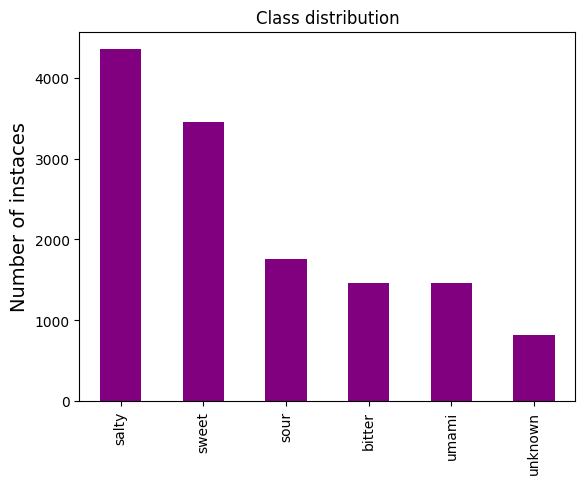

salty      4351
sweet      3449
sour       1761
bitter     1465
umami      1464
unknown     815
Name: Flavor_ingredients, dtype: int64


In [ ]:
# counting how many instances in each class
classDist = df['Flavor_ingredients'].value_counts().plot(kind = 'bar', color= ['purple'],title = 'Class distribution' )
classDist.set_ylabel("Number of instaces",fontsize=14)
plt.show()

# printing the exact number of instances in each class
print (df['Flavor_ingredients'].value_counts())

# **Labeling method 2**

In [ ]:
flavor_dict2 = {
    'sweet': ['cake', 'pie', 'cookies', 'ice cream', 'cherries','pies','vanilla', 'sweet','crumble', 'cobbler', 'parfait', 'caramel', 'pancakes', 'tart', 'granola', 'fruit', 'fruits', 'shortcakes', 'shortcakes', 'crisp', 'waffles', 'pudding', 'cheesecake', 'muffins', 'jam'],
    'salty': ['radish', 'ribs','salad', 'cheese','pasta','soup','shawarma','brisket','lasagna','fish','sliders','steak','chives','miso','chowder','ricotta', 'whiskey','shrimp','feta','chicken', 'oil','turkey','pistachios', 'wonton','dumplings','cured', 'cheddar', 'black pepper' 'meat', 'soup','mayonnaise','pickles', 'bacon', 'pork', 'rice', 'garlic', 'wine', 'potatoes'],
    'bitter': ['coffee','green tea','zucchini','green','tea','hibiscus', 'cilantro','dark chocolate','bourbon', 'nuts','peanuts','pot roast','kale','mint', 'almonds','raspberries','gin','rum','oil','jalapeños','chocolate','whiskey','pineapple','whiskey','rosemary','arugula','campari','radicchio','ginger', 'cocoa powder', 'spinach', 'thyme', 'mayonnaise','oregano', 'brussels sprouts', 'turmeric', 'bitter', 'spinach'],
    'sour': ['citrus','cocktail','tequila','punch','mojito','buttermilk','radish','grapefruit','vinegar', 'sour cream','berries', 'lemon','lemons','oil', 'pistachios','orange','feta','lime juice', 'limes','yogurt', 'cheddar','tomatoes', 'sour', 'kimchi', 'tumeric', 'grapefruit', 'mint', 'onion', 'wine'],
    'umami': ['chicken','miso', 'noodles','ramen','anchovies','scallion','braised','mushrooms', 'eggs','ribs','grilled','egg','peanuts', 'chili','pesto','shrimp','oil','stew','ginger','tomato paste', 'Parmesan cheese','mayonnaise','seaweed', 'mirin','garlic','rice', 'wine', 'bonito flakes', 'pork', 'oyster sauce', 'fermented', 'soy milk', 'broth', 'onions', 'spinach']
}

def determine_flavor_dish(title):
    flavor_counts = {}
    for flavor, keywords in flavor_dict2.items():
        count = 0
        for keyword in keywords:
            if keyword in title.lower():
                count += 1
        if count >= 1:
            flavor_counts[flavor] = count
    if len(flavor_counts) == 0:
        return 'unknown'
    else:
        return max(flavor_counts, key=flavor_counts.get)

# apply the function to the Title column to create a new Flavor column
df['Flavor_dish'] = df['Title'].apply(determine_flavor_dish)

# print the updated DataFrame
df.sample(5)

,Title,Image_Name,Cleaned_Ingredients,Flavor_ingredients,Flavor_dish
1026,Slow-Cooked Summer Squash with Lemon and Thyme,slow-cooked-summer-squash-with-lemon-and-thyme...,"['1 lb. summer squash or zucchini, sliced cros...",salty,bitter
6506,Tuscan Porterhouse Steak with Red Wine-Pepperc...,tuscan-porterhouse-steak-with-red-wine-pepperc...,['1 (1 1/2-pound) porterhouse steak (1- to 1 1...,salty,salty
5765,Buttered Spinach with Vinegar,buttered-spinach-with-vinegar .jpg,"['4 bunches flat-leaf spinach, trimmed, rinsed...",bitter,bitter
13109,Zucchini Frittata with Blossoms,zucchini-frittata-with-blossoms .jpg,"['12 large eggs', '1 cup freshly grated Parmes...",umami,bitter
4208,Spinach-Avocado Smoothie with Grapefruit,spinach-avocado-smoothie-with-grapefruit .jpg,['3/4 cup frozen peeled ruby red grapefruit or...,sweet,bitter


In [ ]:
unknown_flavors2 = df[df['Flavor_dish'] == 'unknown']
unknown_flavors2.sample(20)
#df[df['Title']=='Yaki Onigiri']

,Title,Image_Name,Cleaned_Ingredients,Flavor_ingredients,Flavor_dish
4523,Vitamin C Brew,vitamin-c-brew .jpg,"['2 ounces fresh orange juice', '1 ounce gin',...",unknown,unknown
8406,Sausages with White Beans in Tomato Sauce,sausages-with-white-beans-in-tomato-sauce .jpg,"['2 tablespoons olive oil', '4 garlic cloves, ...",salty,unknown
1819,Honey Brioche,honey-brioche.jpg,"['1/3 cup whole milk, lukewarm', '1 package (a...",sweet,unknown
7697,Red Curry Peanut Sauce,red-curry-peanut-sauce .jpg,"['2 tablespoons vegetable oil', '1/3 cup mince...",umami,unknown
3531,Papadzules,papadzules .jpg,"['2 1/2 cups (657ml) water', '2 large leafy st...",umami,unknown
1221,Fried Meatballs with Tahini Sauce,deep-fried-beef-and-millet-meatballs-with-tahi...,"['1/2 cup millet', '1 lb. ground beef chuck (2...",salty,unknown
13286,Spring Vegetable Ragoût,spring-vegetable-ragout .jpg,"['1 pound leeks', '1pound fennel bulb (sometim...",salty,unknown
9675,Heirloom Tomato Terrine,heirloom-tomato-terrine .jpg,['4 1/2 pounds mixed heirloom tomatoes (2 to 2...,salty,unknown
3816,Sea Bass and Tomato Ceviche,sea-bass-and-tomato-ceviche .jpg,"['1/4 medium red onion, chopped, plus thin sli...",bitter,unknown
2630,3-Ingredient Pumpkin Mousse,-ingredient-pumpkin-mousse.jpg,"['1 (14-ounce) can sweetened condensed milk', ...",unknown,unknown


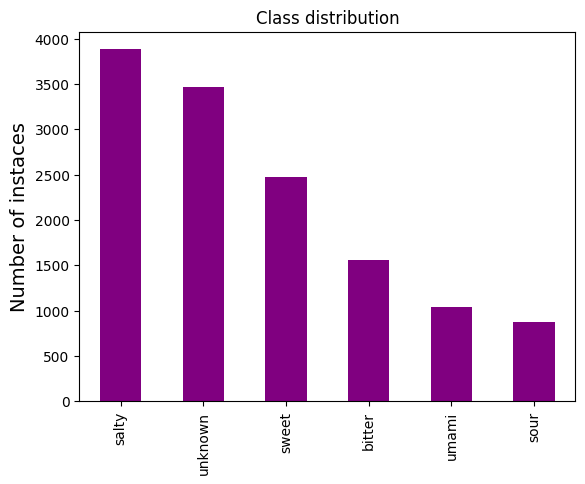

salty      3882
unknown    3469
sweet      2473
bitter     1563
umami      1045
sour        873
Name: Flavor_dish, dtype: int64


In [ ]:
# counting how many instances in each class
classDist = df['Flavor_dish'].value_counts().plot(kind = 'bar', color= ['purple'],title = 'Class distribution' )
classDist.set_ylabel("Number of instaces",fontsize=14)
plt.show()

# printing the exact number of instances in each class
print (df['Flavor_dish'].value_counts())

# **Combining the Two**

In [ ]:
df['Flavor'] = ''
for i, row in df.iterrows():
  #if both methods came to the same conclusion, that flavor is chosen
    if row['Flavor_ingredients'] == row['Flavor_dish']:
        df.loc[i, 'Flavor'] = row['Flavor_ingredients']
  #if one of them is unkown, choose the other
    elif row['Flavor_ingredients'] == 'unknown':
        df.loc[i, 'Flavor'] = row['Flavor_dish']
    elif row['Flavor_dish'] == 'unknown':
        df.loc[i, 'Flavor'] = row['Flavor_ingredients']
  #if they're differnt, choose the one from method 1 (ingredients)
    elif row['Flavor_ingredients'] != row['Flavor_dish']:
        df.loc[i, 'Flavor'] = row['Flavor_ingredients']
df.head()

,Title,Image_Name,Cleaned_Ingredients,Flavor_ingredients,Flavor_dish,Flavor
0,Miso-Butter Roast Chicken With Acorn Squash Pa...,miso-butter-roast-chicken-acorn-squash-panzane...,"['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher...",salty,salty,salty
1,Crispy Salt and Pepper Potatoes,crispy-salt-and-pepper-potatoes-dan-kluger.jpg,"['2 large egg whites', '1 pound new potatoes (...",salty,sweet,salty
2,Thanksgiving Mac and Cheese,thanksgiving-mac-and-cheese-erick-williams.jpg,"['1 cup evaporated milk', '1 cup whole milk', ...",salty,salty,salty
3,Italian Sausage and Bread Stuffing,italian-sausage-and-bread-stuffing .jpg,"['1 (¾- to 1-pound) round Italian loaf, cut in...",umami,unknown,umami
4,Newton's Law,newtons-law-apple-bourbon-cocktail.jpg,"['1 teaspoon dark brown sugar', '1 teaspoon ho...",sweet,unknown,sweet


In [ ]:
# checking the number of rows stilll unlabeled
df[df['Flavor'] == 'unknown'].count()

Title                  427
Image_Name             427
Cleaned_Ingredients    427
Flavor_ingredients     427
Flavor_dish            427
Flavor                 427
dtype: int64

In [ ]:
# dropping unlabeled rows (427) and duplicates
df = df[df['Flavor'] != 'unknown']
df.drop_duplicates(subset=['Image_Name'], inplace=True)

<ipython-input-20-1f57bd71de65>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(subset=['Image_Name'], inplace=True)


In [ ]:
# dropping the flavor ingredients and flavor dish columns since there were used in the final labeling and are not needed anymore
df=df.drop(['Flavor_ingredients', 'Flavor_dish'], axis=1)

In [ ]:
# the final size of the labeled dataset
df.shape[0]

12832

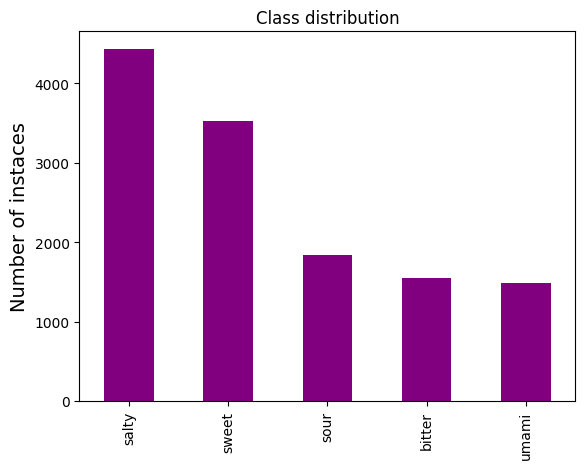

salty     4430
sweet     3526
sour      1836
bitter    1552
umami     1488
Name: Flavor, dtype: int64


In [ ]:
# final class distribution 
classDist = df['Flavor'].value_counts().plot(kind = 'bar', color= ['purple'],title = 'Class distribution' )
classDist.set_ylabel("Number of instaces",fontsize=14)
plt.show()

# printing the exact number of instances in each class
print (df['Flavor'].value_counts())

In [ ]:
# random samples from the data
df.sample(5)
print (df.shape)

(12832, 4)


In [ ]:
# saving the final data file to the drive
df.to_csv('/content/gdrive/My Drive/Dataset/dataset_final.csv', index=False)

# **Generating images using stable diffusion**

In [ ]:
%pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 4.1 MB/s eta 0:00:00


In [ ]:
model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to(device)
pipe.enable_attention_slicing()


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [ ]:
for dish in df['Title']:
  prompt = dish
  image_name = str(df.loc[df['Title'] == prompt, 'Image_Name'].values[0])
  
  # set the path to the directory you are accessing
  directory_path = '/content/gdrive/MyDrive/generated_images/'

  # check if the file exists
  if os.path.isfile(directory_path + image_name):
      print('The file exists.')
  else:
    image = pipe(prompt).images[0]
    image.save(f'/content/gdrive/MyDrive/generated_images/{image_name}')

Streaming output truncated to the last 5000 lines.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exists.
The file exist

**The above cell's output only says "This file exists" because it was run twice, so the images were all already generated.**

# **Data Splitting**

**The final step is to split the data (The text and images) to train and test with 20% testing.**

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/Dataset/dataset_final.csv")
# splitting the DataFrame into train and test DataFrames
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# creating the directory to save the data in if it doesn't exist
save_dir = "/content/gdrive/MyDrive/Dataset/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# saving the train and test DataFrames to CSV files
train_df.to_csv(os.path.join(save_dir, "train.csv"), index=False)
test_df.to_csv(os.path.join(save_dir, "test.csv"), index=False)


In [ ]:
# checking the size of the testing and the training data
train_df = pd.read_csv("/content/gdrive/MyDrive/Dataset/train.csv")
test_df = pd.read_csv("/content/gdrive/MyDrive/Dataset/test.csv")

print ("The size of the training data is: "+str(train_df.shape[0]))
print ("The size of the testing data is: "+str(test_df.shape[0]))

The size of the training data is: 10265
The size of the testing data is: 2567


In [ ]:
folder_path = "/content/gdrive/MyDrive/generated_images/"

# getting the names of the train and test images 
train_images = train_df["Image_Name"].tolist()
test_images = test_df["Image_Name"].tolist()

# creating "train" and "test" folders if they don't exist
train_folder = os.path.join(folder_path, "train")
if not os.path.exists(train_folder):
    os.makedirs(train_folder)

test_folder = os.path.join(folder_path, "test")
if not os.path.exists(test_folder):
    os.makedirs(test_folder)

# moving the train files to the "train" folder
for file in train_images:
    file_path = os.path.join(folder_path, file)
    if os.path.exists(file_path):
        shutil.move(file_path, os.path.join(train_folder, file))

# moving the test files to the "test" folder
for file in test_images:
    file_path = os.path.join(folder_path, file)
    if os.path.exists(file_path):
        shutil.move(file_path, os.path.join(test_folder, file))

print("Files moved successfully!")


Files moved successfully!


In [ ]:
# checking the number of training and testing images
train_path = "/content/gdrive/MyDrive/generated_images/train"
training_images= os.listdir(train_path)

test_path = "/content/gdrive/MyDrive/generated_images/test"
testing_images= os.listdir(test_path)

print ("The size of the training data is: "+str(len(training_images)))
print ("The size of the testing data is: "+str(len(testing_images)))

The size of the training data is: 10265
The size of the testing data is: 2567


In [ ]:
# set the path of the directory containing the train and test folders
folder_path = "/content/gdrive/MyDrive/generated_images/train"

# create folders for each class
class_names = train_df["Flavor"].unique()

for class_name in class_names:
    class_folder = os.path.join(folder_path, class_name)
    if not os.path.exists(class_folder):
        os.makedirs(class_folder)

# move images to corresponding class folders

src_folder = folder_path
for filename in os.listdir(src_folder):
    row = train_df.loc[train_df["Image_Name"] == filename]
    if not row.empty:
        class_name = row["Flavor"].iloc[0]
        src_path = os.path.join(src_folder, filename)
        dest_path = os.path.join(folder_path, class_name, filename)
        shutil.move(src_path, dest_path)

print("Files moved successfully!")

Files moved successfully!


In [ ]:
# set the path of the directory containing the train and test folders
folder_path = "/content/gdrive/MyDrive/generated_images/test"

# create folders for each class
class_names = test_df["Flavor"].unique()

for class_name in class_names:
    class_folder = os.path.join(folder_path, class_name)
    if not os.path.exists(class_folder):
        os.makedirs(class_folder)

# move images to corresponding class folders

src_folder = folder_path
for filename in os.listdir(src_folder):
    row = test_df.loc[test_df["Image_Name"] == filename]
    if not row.empty:
        class_name = row["Flavor"].iloc[0]
        src_path = os.path.join(src_folder, filename)
        dest_path = os.path.join(folder_path, class_name, filename)
        shutil.move(src_path, dest_path)

print("Files moved successfully!")

Files moved successfully!


# **Downsampled**

**Creating a Downsampeld version of the dataset with only 6250 samples, 5000 for training and 1250 for testing for a 80:20 ratio.**

In [ ]:
data_folder = "/content/gdrive/MyDrive/generated_images_downsampled"

train_folder = os.path.join(data_folder, "train")
test_folder = os.path.join(data_folder, "test")


class_names = ['sweet', 'salty', 'umami', 'sour', 'bitter']


train_df = pd.read_csv('/content/gdrive/MyDrive/Dataset/train.csv')
test_df = pd.read_csv('/content/gdrive/MyDrive/Dataset/test.csv')


train_new_df = pd.DataFrame(columns=train_df.columns)
test_new_df = pd.DataFrame(columns=test_df.columns)


for class_name in class_names:
    class_folder = os.path.join(train_folder, class_name)
    for filename in os.listdir(class_folder):
        if filename in train_df['Image_Name'].values:
            train_new_df = train_new_df.append(train_df[train_df['Image_Name'] == filename], ignore_index=True)

for class_name in class_names:
    class_folder = os.path.join(test_folder, class_name)  
    for filename in os.listdir(class_folder):
        if filename in test_df['Image_Name'].values:
            test_new_df = test_new_df.append(test_df[test_df['Image_Name'] == filename], ignore_index=True)


save_dir = '/content/gdrive/MyDrive/Dataset/'

train_new_df.to_csv(os.path.join(save_dir, "downsampled_train_df.csv"), index=False)
test_new_df.to_csv(os.path.join(save_dir, "downsampled_test_df.csv"), index=False)


<ipython-input-45-3031f8cda2bc>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_new_df = train_new_df.append(train_df[train_df['Image_Name'] == filename], ignore_index=True)
<ipython-input-45-3031f8cda2bc>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_new_df = test_new_df.append(test_df[test_df['Image_Name'] == filename], ignore_index=True)


In [ ]:
downsampled_train_df =  pd.read_csv('/content/gdrive/MyDrive/Dataset/downsampled_train_df.csv')
downsampled_test_df =  pd.read_csv('/content/gdrive/MyDrive/Dataset/downsampled_test_df.csv')